In [84]:
from collections import Counter
import glob
import hashlib
import io
import math
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tarfile
from urllib import urlretrieve
%matplotlib inline
from stemming.porter2 import stem
import numpy as np
import cvxopt
from cvxopt import solvers, matrix
import operator
from sklearn import metrics
import random
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
%matplotlib inline
import math
from scipy.spatial.distance import pdist,squareform
from sklearn.preprocessing import PolynomialFeatures
import timeit
import nltk
from sklearn.naive_bayes import GaussianNB

In [85]:
def get_files(path):
    """ Return a list of file names in this directory that end in .txt 
    The list should be sorted alphabetically by file name.
    Params:
        path....a directory containing .txt review files.
    Returns:
        a list of .txt file names, sorted alphabetically.
    """
    
    text_files = [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.txt')]
    
    return sorted(text_files)

In [86]:
def get_true_labels(file_names):
    """Return a *numpy array* of ints for the true sentiment labels of each file.
    1 means positive, 0 means negative. Use the name of the file to determine
    the true label.
    Params:
        file_names....a list of .txt file paths, e.g., data/train/pos/10057_9.txt
    Returns:
        a numpy array of 1 or 0 values corresponding to each element
        of file_names, where 1 indicates a positive review, and 0
        indicates a negative review.
    """
   
    senti=[]
    for files in file_names:
        if re.search("pos",files):
            senti.extend([1])
        else:
            senti.extend([0])
    return np.array(senti)    



In [87]:
# Part of Speach tagging for feature selection
POS = ['JJ','JJR','MD','PDT','RB','RBR','RP','VB','VBP','VBD','VBG','VBN','VBZ']

In [88]:
# Here's what a positive review looks like.
def file2string(filename):
    return io.open(filename, encoding='utf8').readlines()[0]

In [89]:
def tokenize_with_POS(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is removed. Note that
    underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    
    words = nltk.word_tokenize(text)
    
    wlist=[]
    
    for w,t in nltk.pos_tag(words):
        
        if t in POS:
            wlist.append(w)
        
    return wlist

tokenize_with_POS("I think that the idea of the plot is perfect for exploring first of all the emotional experiences of the people involved and second")

['think',
 'is',
 'perfect',
 'exploring',
 'first',
 'all',
 'emotional',
 'involved',
 'second']

In [90]:
def tokenize(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is removed. Note that
    underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    
    words=[]
    
    for s in re.sub('\W+', ' ', text.lower()).split():
        words.append((s))
    return words

In [91]:
def tokenize_with_stemming(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is removed. Note that
    underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    templ =re.split("(\W)+?",text.lower()) 
    l= [stem(r) for r in templ if r.strip()]
    for index,word in enumerate(l):
        word = stem(word)
        if ((word.lower())=="not"):
            if(len(l)>index+1):
                l[index+1]="not_"+l[index+1]
            if(len(l)>index+2):
                l[index+2]="not_"+l[index+2]
    return l

tokenize_with_stemming("Hi! How's it going??? an_underscore is not *really* punctuation.")

['hi',
 '!',
 'how',
 "'",
 's',
 'it',
 'go',
 '?',
 '?',
 '?',
 'an_underscor',
 'is',
 'not',
 'not_*',
 'not_realli',
 '*',
 'punctuat',
 '.']

In [92]:
def get_stop_words(filename):
    """  English Stop words provided by Stanford Lingustics"""
    stoplist= []
    with open(filename) as fileobject:
        stoplist = [ w.replace('\n','') for w in fileobject.readlines() ]
    return stoplist
stoplist = get_stop_words("stop.txt")

In [93]:
def repeatable_random(seed):
    """ shfulling the samples in random order to avoid static fitting """
    hash = str(seed)
    while True:
        hash = hashlib.md5(hash).digest()
        for c in hash:
            yield ord(c)

def repeatable_shuffle(X, y, filenames):
    r = repeatable_random(42) 
    indices = sorted(range(X.shape[0]), key=lambda x: next(r))
    return X[indices], y[indices], np.array(filenames)[indices]

In [94]:
def do_vectorize(filenames,stop_words=stoplist, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        filenames.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
   
    if (isinstance(filenames,list)==False):
        filenames = filenames.tolist()
    
    vectorizer = CountVectorizer(input="filename",stop_words=stoplist,tokenizer=tokenizer_fn,min_df=min_df,max_df=max_df,binary=binary,ngram_range=ngram_range,dtype=int)
    X = vectorizer.fit_transform(eachfile for eachfile in filenames)
    return (X,vectorizer)


In [95]:
def do_expt(filenames, y, tokenizer_fn=tokenize_with_POS,
            min_df=1,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,1), n_folds=5):
    """
    Run one experiment, which consists of vectorizing each file,
    performing cross-validation, and returning the average accuracy.
    You should call do_vectorize and do_cross_validation here.
    Params:
        filenames.......list of review file names
        y...............the true sentiment labels for each file
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
        
    Returns:
        Top Positive and Negative Co-efficients. 
    """
   
   
    matrix1, vec = do_vectorize(filenames,stop_words, tokenizer_fn=tokenizer_fn, min_df=min_df,max_df=max_df, binary=binary, ngram_range=ngram_range)
    clf = LogisticRegression(random_state=42)
    clf.fit(matrix1,y)
    feature_names = vec.get_feature_names()
    
    top_pos = sorted(sorted(zip(clf.coef_[0], feature_names))[-20:],reverse=True)
    top_neg = sorted(sorted(zip(clf.coef_[0], feature_names))[:20])
    return top_pos,top_neg

pos_train_files = get_files("data" + os.sep + 'train' + os.sep + 'pos')
neg_train_files = get_files("data" + os.sep + 'train' + os.sep + 'neg')
all_train_files = pos_train_files + neg_train_files

y= get_true_labels(all_train_files)
top_pos ,top_neg =  do_expt(all_train_files, y)
print "Top postive Co-efficients: "
print top_pos
print "\n Top Negative Co-efficients: "
print top_neg




Top postive Co-efficients: 
[(0.76481850215725622, u'great'), (0.76048804020699867, u'excellent'), (0.66125758551728364, u'never'), (0.60234129395922431, u"'d"), (0.59417533424060176, u'superb'), (0.56970028174454435, u'back'), (0.54575595599943894, u'ago'), (0.5341933356702695, u'amazing'), (0.50171220324076504, u'watch'), (0.49639053321210036, u'liked'), (0.47863232868477373, u'worth'), (0.47802820013861308, u'loved'), (0.4759642465924474, u'still'), (0.47241388919427929, u'truly'), (0.47130954734427605, u'else'), (0.46774881707965466, u'especially'), (0.45552171058649343, u'emotional'), (0.45316169861706707, u'sees'), (0.4503474539202616, u'know'), (0.43809613472050796, u'enjoyed')]

 Top Negative Co-efficients: 
[(-0.78126164334045312, u'boring'), (-0.76094935479584758, u'bad'), (-0.70387608563508197, u'terrible'), (-0.69195712060098136, u'watching'), (-0.68830478400236272, u'out'), (-0.64493639576673778, u'can'), (-0.61371330717507044, u'care'), (-0.61083265798658848, u'poor'), (-

In [101]:
def experiment(path,tokenizer_fn=tokenize,min_df=1,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,1)):
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        filenames.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
    Training X , Y ; Test X,Y  """
    
    pos_train_files = get_files(path + os.sep + 'train' + os.sep + 'pos')
    neg_train_files = get_files(path + os.sep + 'train' + os.sep + 'neg')
    all_train_files = pos_train_files + neg_train_files
    
    labels = get_true_labels(all_train_files)

    pos_test_files = get_files(path + os.sep + 'test' + os.sep + 'pos')
    neg_test_files = get_files(path + os.sep + 'test' + os.sep + 'neg')
    all_test_files = pos_test_files + neg_test_files
    
   
    print tokenize

    matrix, vec = do_vectorize(all_train_files,tokenizer_fn=tokenizer_fn,
            min_df=min_df,stop_words=None, max_df=max_df, binary=True,
            ngram_range=(1,1))
    X_test = vec.transform(all_test_files)
    y_test = np.array([1] * len(pos_test_files) + [0] * len(neg_test_files))
    
    X, y, filenames = repeatable_shuffle(matrix, labels, all_train_files)

    print "Number of Features :",X.shape
    return X, y, X_test,y_test




In [102]:
def confussion_matrix(y_cap,y,cls=1):
    """ Compute the confussion matrix for the given predicted and actual classes """
    a=0
    b=0
    c=0
    d=0
    for i in range(0,len(y)):        
        if y[i]==cls and y_cap[i] ==cls:
            a+=1
        elif y[i]!=cls and y_cap[i] ==cls:
            c+=1
        elif y[i]==cls and y_cap[i] !=cls:
            b+=1
        elif y[i]!=cls and y_cap[i] !=cls:
            d+=1
    return float(a),float(b),float(c),float(d)

In [103]:
def evaluate_performance(y_Cap,y,cls):
    """ Using the Confusion matrix , the metric like Accuracy , Precision , Recall , F square measures are computed """
    a,b,c,d = confussion_matrix(y_Cap,y,cls)
    r =0 
    p= 0
    if a+b+c+d!=0:
        print "Accuracy \t:",(a+d)/(a+b+c+d)
    else: 
        print "Can't Compute Accurancy"
    if c+d !=0:
        
        r = (d)/(c+d)
        print "Recall  \t:",r
        print "False Negative \t:",c/(c+d)
    else: 
        print "Can't Compute Recall and False Negative"
        r=0
    if b+d!=0:    
        p = d/(b+d)
        print "Precision \t:",p
    else: 
        print "Can't Compute Precision "
        p=0
    if a+b!=0:
        print "False Positive \t:",b/(a+b)
        print "True Negative \t:",a/(a+b)
    else:
         print "Can't Compute False Positive and True Negatice"
    if p+r !=0:
        print "F Square \t:",2*(p*r)/(p+r)
    else:
        print"Can't Compute F Square"
    return p,r

### Logistic Regression

In [104]:
def classify_LR(thetas, x):
    """ Predicts the Class based on sigmoid value  """
    if sigmoid(thetas,x) > 0.5:
        return 1
    else:
        return 0


In [105]:
def classify_all_LR(x,data,y):
    """ Computes Parameters and predicts the labels for test data  
    Input: 
    X= Testing Samples
    Data = Training Samples
    y = training laels
    Returns:
    predictedLabels
    """
    thetas = gradient_descent_LR(data,y)
    predictedLabels = []
    for i in range(0,x.shape[0]):
        predictedLabels.append(classify_LR(thetas,x[i]))
    for l in np.unique(y):
        print " \n Metrics For Class",l,"......."
        p,r = evaluate_performance(predictedLabels,Y_test,1)
    return predictedLabels

In [106]:
def sigmoid(thetas, x):
    """ Computes the Sigmoid Values """
    return 1 / (1 + exp(-np.dot(np.transpose(thetas),x)))

In [107]:
def gradient_descent_LR(x,y,maxIterations=1000,learning_rate=0.003):
    """ Computes parameter theta usign gradient descent algorithm  """
    iterations = 0
    m,n = np.shape(x)
    thetas = np.ones(n)
    while(iterations < maxIterations):
        gradient=0
        for i in range(x.shape[0]):
            h = sigmoid(thetas,x[i])
            gradient += (h - y[i]) * x[i]
        new_thetas = thetas - (learning_rate*gradient)
        iterations += 1
        thetas = new_thetas
    return thetas

### SVM - Algorithm Implementation 

In [108]:
def Gaussian(X):
    """ Gaussian Function as kernel """
    distance = squareform(pdist(X))
    sigma = np.std(X)
    G = np.exp(-(distance**2)/(2*sigma**2))
    return G

In [109]:
def classify_all(X,w,w0):
    """Predicts all the labels based on the parameters w and w0 """
    predictedLabels = list()
    for i in range(0,X.shape[0]):
        predictedLabels.append(classify(X[i],w,w0))
    return predictedLabels

In [110]:
def classify(x,w,w0):
    """Predicts the labels based on the parameters w and w0 """
    if(np.dot(w, x) + w0 > 0):
        return 1
    else:
        return -1

In [111]:
def find_alpha(X,y,mtype,c=999,type='linear'):
    """ Computing w,w0 using cvxopt's qp solver  """
    m = X.shape[0]
    n = X.shape[1]
    #p
    if(type == 'linear'):
        gm = np.dot(X, X.T)
    elif (type == 'gaussian'):
        gm= Gaussian(X)
    elif (type == 'polynomial'):
        Z = polynomial(X,2)
        gm= np.dot(Z,Z.T)
    
    P = np.dot(y,y.T) * gm
    P = cvxopt.matrix(P)
    #q
    
    q = np.empty([m, 1])
    q.fill(-1)
    q = cvxopt.matrix(q)
    
    if mtype == 'soft':
        G = np.zeros([2*m, m])
        np.fill_diagonal(G,-1)
        np.fill_diagonal(G[m:,],1)
        G = cvxopt.matrix(G)
    #h
        h = np.empty([2*m,1])
        h.fill(0)
        for i in range(m,2*m):
            h[i]=c
        h = cvxopt.matrix(h)
    else:
    #G
        G = np.zeros([m, m])
        np.fill_diagonal(G,-1)
        G = cvxopt.matrix(G)

    #h
        h = np.empty([m,1])
        h.fill(0)
        h = cvxopt.matrix(h)
    #A
    A = cvxopt.matrix(y).T
    #b
    b = cvxopt.matrix(0.0)

    #solve for alphas
    alphas = np.matrix(solvers.qp(P, q, G, h, A, b)['x'])
    return cvxopt.matrix(alphas)

In [112]:
def train(alphas,X,y,eps):
    """ Compute parameter alpha based on w,w0  """
    m,n = X.shape
    w = np.zeros([1,n])
    for i in range(m):
        w += alphas[i] * y[i] * X[i]
    #calculate w0
    sv_idx = [ sv for sv in range(len(alphas)) if alphas[sv] > eps]
    
    w0 = 0
    for i in sv_idx:
        w0 += (y[i] - np.dot(w,X[i]))
    if(w0 != 0):
        w0 = w0/len(sv_idx)

    return w,w0, sv_idx

In [113]:
def label_update(Y_train,Y_test):
    for i in range(0,len(Y_train)):
        if(Y_train[i]==0):
            Y_train[i] = -1
    Y_train = Y_train.astype(float)


    for i in range(0,len(Y_test)):
        if(Y_test[i]==0):
            Y_test[i] = -1
    Y_test = Y_test.astype(float)
    
    return Y_train,Y_test


In [114]:
def classify_SVM(X_train, Y_train, X_test,Y_test):
    """ Wrapper Function to SVM Train , find parameter and predict """
    Y_train,Y_test = label_update(Y_train,Y_test)
    alphas = find_alpha(X_train.toarray(),Y_train,'soft',c=1,type="gaussian")
    w,w0,idx = train(alphas,X_train.toarray(),Y_train,0.5)
    predicted_labels = classify_all(X_test.toarray(),w,w0)
    print "\n........... For Class Positive........................" 
    p,r = evaluate_performance(predicted_labels,Y_test,1)

    print "\n............For Class Negative........................" 
    p,r = evaluate_performance(predicted_labels,Y_test,-1)
    return predicted_labels


In [115]:
def plot_features(counter,label,xlabel,title):
    """Plots the Bar Graph from the contens of the counter variable
    Params:
    1. counter : frequency
    2. label   : list of labels. 
    """
    fig = plt.figure()
    
    y_pos = np.arange(len(label))
    # get the counts for each key, assuming the values are numerical
    values = [counter[k] for k in range(0,len(label))]
    print values
    plt.plot(y_pos,values,marker='o')
    plt.xticks(y_pos, label)
    plt.xlabel(xlabel)
    plt.title(title)

    plt.show()
    
    

#  IMDB Movie Review Text Classifiers  

#### Data :  400 reviews as trainning samples, 200 as test set 


### Logistic Regression

### Feature Extraction with normal Tokenize

In [116]:
## Using LR

Features=[]
times=[]
accuracies=[]

print "\n With TF-IDF Tokenize "

X_train, Y_train, X_test,Y_test = experiment("data",tokenizer_fn=tokenize,min_df=2,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))

Features.append(X_train.shape[1])
start_time = timeit.default_timer()
predictedLabels = classify_all_LR(X_test.toarray(),X_train.toarray(),Y_train)
end_time = timeit.default_timer()

times.append(end_time - start_time)




accuracies.append(accuracy_score(predictedLabels,Y_test))




 With TF-IDF Tokenize 
<function tokenize at 0x0000000031692198>
Number of Features : (400, 4524)
 
 Metrics For Class 0 .......
Accuracy 	: 0.68
Recall  	: 0.765
False Negative 	: 0.235
Precision 	: 0.653846153846
False Positive 	: 0.405
True Negative 	: 0.595
F Square 	: 0.705069124424
 
 Metrics For Class 1 .......
Accuracy 	: 0.68
Recall  	: 0.765
False Negative 	: 0.235
Precision 	: 0.653846153846
False Positive 	: 0.405
True Negative 	: 0.595
F Square 	: 0.705069124424


### Feature Extraction for Tokenize with Stemming

In [117]:
X_train, Y_train, X_test,Y_test = experiment("data",tokenizer_fn=tokenize_with_stemming,min_df=2,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))
print "\n Considering Stemming of Features"
Features.append(X_train.shape[1])
start_time = timeit.default_timer()
predictedLabels = classify_all_LR(X_test.toarray(),X_train.toarray(),Y_train)
end_time = timeit.default_timer()

times.append(end_time - start_time)



accuracies.append(accuracy_score(predictedLabels,Y_test))


<function tokenize at 0x0000000031692198>
Number of Features : (400, 3835)

 Considering Stemming of Features
 
 Metrics For Class 0 .......
Accuracy 	: 0.6925
Recall  	: 0.775
False Negative 	: 0.225
Precision 	: 0.665236051502
False Positive 	: 0.39
True Negative 	: 0.61
F Square 	: 0.715935334873
 
 Metrics For Class 1 .......
Accuracy 	: 0.6925
Recall  	: 0.775
False Negative 	: 0.225
Precision 	: 0.665236051502
False Positive 	: 0.39
True Negative 	: 0.61
F Square 	: 0.715935334873


### Feature Extraction for Tokenize with POS

In [118]:
X_train, Y_train, X_test,Y_test = experiment("data",tokenizer_fn=tokenize_with_POS,min_df=2,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))
print "\n Considering Part of Speech of Features"
Features.append(X_train.shape[1])
start_time = timeit.default_timer()
predictedLabels = classify_all_LR(X_test.toarray(),X_train.toarray(),Y_train)
end_time = timeit.default_timer()

times.append(end_time - start_time)


accuracies.append(accuracy_score(predictedLabels,Y_test))

<function tokenize at 0x0000000031692198>
Number of Features : (400, 2224)

 Considering Part of Speech of Features
 
 Metrics For Class 0 .......
Accuracy 	: 0.675
Recall  	: 0.745
False Negative 	: 0.255
Precision 	: 0.65350877193
False Positive 	: 0.395
True Negative 	: 0.605
F Square 	: 0.696261682243
 
 Metrics For Class 1 .......
Accuracy 	: 0.675
Recall  	: 0.745
False Negative 	: 0.255
Precision 	: 0.65350877193
False Positive 	: 0.395
True Negative 	: 0.605
F Square 	: 0.696261682243


### Graph Plot

[4524, 3835, 2224]


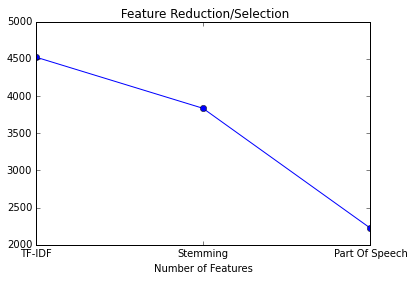

[16.256589728764084, 12.967765111599874, 7.010009682097007]


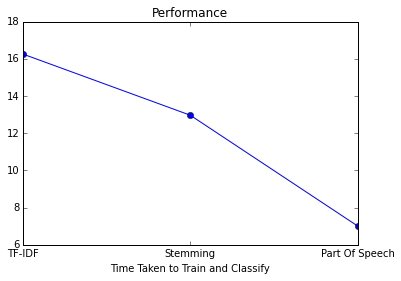

[0.68000000000000005, 0.6925, 0.67500000000000004]


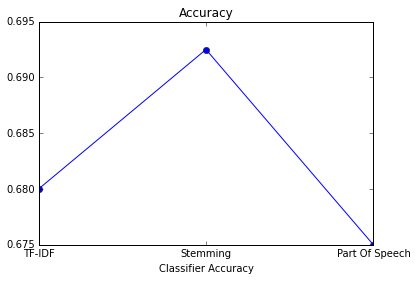

In [119]:
ylabel = ['TF-IDF','Stemming','Part Of Speech']
 
plot_features(Features,ylabel,"Number of Features"," Feature Reduction/Selection")
plot_features(times,ylabel,"Time Taken to Train and Classify","Performance")
plot_features(accuracies,ylabel,"Classifier Accuracy","Accuracy")

### GNB

### Feature Extraction with normal Tokenize

In [120]:
gnb = GaussianNB()
X_train, Y_train, X_test,Y_test = experiment("data",tokenizer_fn=tokenize,min_df=2,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))
print "\n Considering Part of Speech of Features"
Features.append(X_train.shape[1])
start_time = timeit.default_timer()
predictedLabels = gnb.fit(X_train.toarray(),Y_train).predict(X_test.toarray())
for l in np.unique(Y_test):
    print " \n Metrics For Class",l,"......."
    p,r = evaluate_performance(predictedLabels,Y_test,1)
end_time = timeit.default_timer()

times.append(end_time - start_time)


accuracies.append(accuracy_score(predictedLabels,Y_test))

<function tokenize at 0x0000000031692198>
Number of Features : (400, 4524)

 Considering Part of Speech of Features
 
 Metrics For Class 0 .......
Accuracy 	: 0.6525
Recall  	: 0.72
False Negative 	: 0.28
Precision 	: 0.63436123348
False Positive 	: 0.415
True Negative 	: 0.585
F Square 	: 0.674473067916
 
 Metrics For Class 1 .......
Accuracy 	: 0.6525
Recall  	: 0.72
False Negative 	: 0.28
Precision 	: 0.63436123348
False Positive 	: 0.415
True Negative 	: 0.585
F Square 	: 0.674473067916


###  Feature Extraction with Tokenize with Stemming

In [121]:
gnb = GaussianNB()
X_train, Y_train, X_test,Y_test = experiment("data",tokenizer_fn=tokenize_with_stemming,min_df=2,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))
print "\n Considering Part of Speech of Features"
Features.append(X_train.shape[1])
start_time = timeit.default_timer()
predictedLabels = gnb.fit(X_train.toarray(),Y_train).predict(X_test.toarray())
for l in np.unique(Y_test):
    print " \n Metrics For Class",l,"......."
    p,r = evaluate_performance(predictedLabels,Y_test,1)
end_time = timeit.default_timer()

times.append(end_time - start_time)


accuracies.append(accuracy_score(predictedLabels,Y_test))



<function tokenize at 0x0000000031692198>
Number of Features : (400, 3835)

 Considering Part of Speech of Features
 
 Metrics For Class 0 .......
Accuracy 	: 0.6825
Recall  	: 0.705
False Negative 	: 0.295
Precision 	: 0.674641148325
False Positive 	: 0.34
True Negative 	: 0.66
F Square 	: 0.689486552567
 
 Metrics For Class 1 .......
Accuracy 	: 0.6825
Recall  	: 0.705
False Negative 	: 0.295
Precision 	: 0.674641148325
False Positive 	: 0.34
True Negative 	: 0.66
F Square 	: 0.689486552567


### Feature Extraction with Tokenize with POS

In [122]:
gnb = GaussianNB()
X_train, Y_train, X_test,Y_test = experiment("data",tokenizer_fn=tokenize_with_POS,min_df=2,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))
print "\n Considering Part of Speech of Features"
Features.append(X_train.shape[1])
start_time = timeit.default_timer()
predictedLabels = gnb.fit(X_train.toarray(),Y_train).predict(X_test.toarray())
for l in np.unique(Y_test):
    print " \n Metrics For Class",l,"......."
    p,r = evaluate_performance(predictedLabels,Y_test,1)
end_time = timeit.default_timer()

times.append(end_time - start_time)


accuracies.append(accuracy_score(predictedLabels,Y_test))

<function tokenize at 0x0000000031692198>
Number of Features : (400, 2224)

 Considering Part of Speech of Features
 
 Metrics For Class 0 .......
Accuracy 	: 0.6575
Recall  	: 0.57
False Negative 	: 0.43
Precision 	: 0.690909090909
False Positive 	: 0.255
True Negative 	: 0.745
F Square 	: 0.624657534247
 
 Metrics For Class 1 .......
Accuracy 	: 0.6575
Recall  	: 0.57
False Negative 	: 0.43
Precision 	: 0.690909090909
False Positive 	: 0.255
True Negative 	: 0.745
F Square 	: 0.624657534247


### Graph Plot

[4524, 3835, 2224]


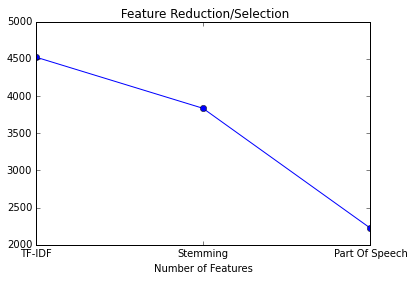

[16.256589728764084, 12.967765111599874, 7.010009682097007]


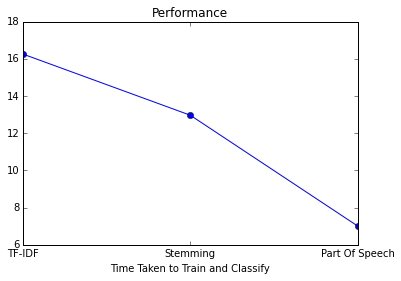

[0.68000000000000005, 0.6925, 0.67500000000000004]


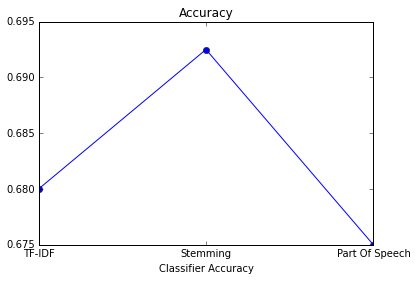

In [123]:
ylabel = ['TF-IDF','Stemming','Part Of Speech']
 
plot_features(Features,ylabel,"Number of Features"," Feature Reduction/Selection")
plot_features(times,ylabel,"Time Taken to Train and Classify","Performance")
plot_features(accuracies,ylabel,"Classifier Accuracy","Accuracy")

### SVM

### Feature Extraction with normal Tokenize

In [124]:
Features=[]
times=[]
accuracies=[]


#Normal Tokenize , no stop , stem SVM 
X_train, Y_train, X_test,Y_test = experiment("data",tokenizer_fn=tokenize,min_df=2,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))


Features.append(X_train.shape[1])
start_time = timeit.default_timer()

predictedLabels = classify_SVM(X_train, Y_train, X_test,Y_test)

end_time = timeit.default_timer()
times.append(end_time - start_time)
accuracies.append(accuracy_score(predictedLabels,Y_test))

<function tokenize at 0x0000000031692198>
Number of Features : (400, 4524)
     pcost       dcost       gap    pres   dres
 0: -9.9007e-03 -4.0198e+02  4e+02  2e-17  1e-16
 1: -4.4989e-01 -4.8667e+00  4e+00  2e-16  6e-17
 2: -4.9968e-01 -5.6552e-01  7e-02  2e-16  4e-17
 3: -5.0000e-01 -5.0068e-01  7e-04  2e-16  1e-16
 4: -5.0000e-01 -5.0001e-01  7e-06  8e-17  7e-17
 5: -5.0000e-01 -5.0000e-01  7e-08  2e-16  6e-17
Optimal solution found.

........... For Class Positive........................
Accuracy 	: 0.785
Recall  	: 0.88
False Negative 	: 0.12
Precision 	: 0.739495798319
False Positive 	: 0.31
True Negative 	: 0.69
F Square 	: 0.803652968037

............For Class Negative........................
Accuracy 	: 0.785
Recall  	: 0.69
False Negative 	: 0.31
Precision 	: 0.851851851852
False Positive 	: 0.12
True Negative 	: 0.88
F Square 	: 0.762430939227


### Feature Extraction  Tokenize with Stemming

In [125]:
X_train,Y_train,X_test,Y_test =   experiment("data",tokenizer_fn=tokenize_with_stemming,min_df=2,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))

Features.append(X_train.shape[1])
start_time = timeit.default_timer()

predictedLabels = classify_SVM(X_train, Y_train, X_test,Y_test)

end_time = timeit.default_timer()
times.append(end_time - start_time)
accuracies.append(accuracy_score(predictedLabels,Y_test))

<function tokenize at 0x0000000031692198>
Number of Features : (400, 3835)
     pcost       dcost       gap    pres   dres
 0: -9.9007e-03 -4.0198e+02  4e+02  2e-17  1e-16
 1: -4.4989e-01 -4.8667e+00  4e+00  2e-16  6e-17
 2: -4.9968e-01 -5.6552e-01  7e-02  2e-16  4e-17
 3: -5.0000e-01 -5.0068e-01  7e-04  2e-16  1e-16
 4: -5.0000e-01 -5.0001e-01  7e-06  8e-17  7e-17
 5: -5.0000e-01 -5.0000e-01  7e-08  2e-16  6e-17
Optimal solution found.

........... For Class Positive........................
Accuracy 	: 0.7625
Recall  	: 0.945
False Negative 	: 0.055
Precision 	: 0.692307692308
False Positive 	: 0.42
True Negative 	: 0.58
F Square 	: 0.799154334038

............For Class Negative........................
Accuracy 	: 0.7625
Recall  	: 0.58
False Negative 	: 0.42
Precision 	: 0.913385826772
False Positive 	: 0.055
True Negative 	: 0.945
F Square 	: 0.709480122324


### Feature Extraction  Tokenize with POS

In [126]:
X_train,Y_train,X_test,Y_test =   experiment("data",tokenizer_fn=tokenize_with_POS,min_df=2,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))
Features.append(X_train.shape[1])
start_time = timeit.default_timer()

predictedLabels = classify_SVM(X_train, Y_train, X_test,Y_test)

end_time = timeit.default_timer()
times.append(end_time - start_time)
accuracies.append(accuracy_score(predictedLabels,Y_test))

<function tokenize at 0x0000000031692198>
Number of Features : (400, 2224)
     pcost       dcost       gap    pres   dres
 0: -9.9007e-03 -4.0198e+02  4e+02  2e-17  1e-16
 1: -4.4989e-01 -4.8667e+00  4e+00  2e-16  6e-17
 2: -4.9968e-01 -5.6552e-01  7e-02  2e-16  4e-17
 3: -5.0000e-01 -5.0068e-01  7e-04  2e-16  1e-16
 4: -5.0000e-01 -5.0001e-01  7e-06  8e-17  7e-17
 5: -5.0000e-01 -5.0000e-01  7e-08  2e-16  6e-17
Optimal solution found.

........... For Class Positive........................
Accuracy 	: 0.7675
Recall  	: 0.795
False Negative 	: 0.205
Precision 	: 0.75355450237
False Positive 	: 0.26
True Negative 	: 0.74
F Square 	: 0.773722627737

............For Class Negative........................
Accuracy 	: 0.7675
Recall  	: 0.74
False Negative 	: 0.26
Precision 	: 0.783068783069
False Positive 	: 0.205
True Negative 	: 0.795
F Square 	: 0.760925449871


### Graph Plot

[4524, 3835, 2224]


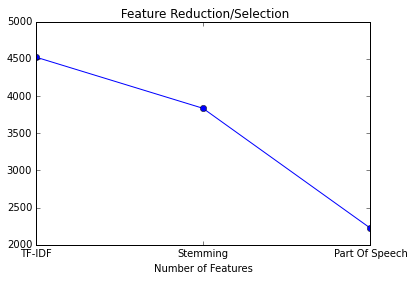

[0.5909377437637886, 0.5488441353227245, 0.341821278037969]


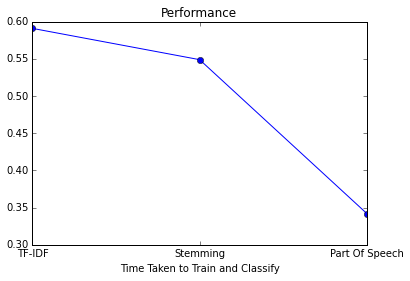

[0.78500000000000003, 0.76249999999999996, 0.76749999999999996]


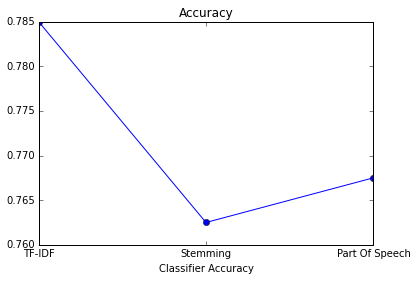

In [127]:
ylabel = ['TF-IDF','Stemming','Part Of Speech']
 
plot_features(Features,ylabel,"Number of Features"," Feature Reduction/Selection")
plot_features(times,ylabel,"Time Taken to Train and Classify","Performance")
plot_features(accuracies,ylabel,"Classifier Accuracy","Accuracy")

#  Yelp Restraunt Review Text Classifiers  

#### Data :  204 reviews as trainning samples, 100 as test set 


### Logistic Regression

### Feature Extraction with normal Tokenize

In [128]:
## Using LR

Features=[]
times=[]
accuracies=[]

print "\n With TF-IDF Tokenize "

X_train, Y_train, X_test,Y_test = experiment("ML_Data",tokenizer_fn=tokenize,min_df=8,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))

Features.append(X_train.shape[1])
start_time = timeit.default_timer()
predictedLabels = classify_all_LR(X_test.toarray(),X_train.toarray(),Y_train)
end_time = timeit.default_timer()

times.append(end_time - start_time)




accuracies.append(accuracy_score(predictedLabels,Y_test))




 With TF-IDF Tokenize 
<function tokenize at 0x0000000031692198>
Number of Features : (314, 106)
 
 Metrics For Class 0 .......
Accuracy 	: 0.736363636364
Recall  	: 0.80701754386
False Negative 	: 0.19298245614
Precision 	: 0.71875
False Positive 	: 0.339622641509
True Negative 	: 0.660377358491
F Square 	: 0.760330578512
 
 Metrics For Class 1 .......
Accuracy 	: 0.736363636364
Recall  	: 0.80701754386
False Negative 	: 0.19298245614
Precision 	: 0.71875
False Positive 	: 0.339622641509
True Negative 	: 0.660377358491
F Square 	: 0.760330578512


### Feature Extraction Tokenize With Stemming

In [129]:
X_train, Y_train, X_test,Y_test = experiment("ML_Data",tokenizer_fn=tokenize_with_stemming,min_df=8,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))
print "\n Considering Stemming of Features"
Features.append(X_train.shape[1])
start_time = timeit.default_timer()
predictedLabels = classify_all_LR(X_test.toarray(),X_train.toarray(),Y_train)
end_time = timeit.default_timer()

times.append(end_time - start_time)



accuracies.append(accuracy_score(predictedLabels,Y_test))


<function tokenize at 0x0000000031692198>
Number of Features : (314, 137)

 Considering Stemming of Features
 
 Metrics For Class 0 .......
Accuracy 	: 0.763636363636
Recall  	: 0.824561403509
False Negative 	: 0.175438596491
Precision 	: 0.746031746032
False Positive 	: 0.301886792453
True Negative 	: 0.698113207547
F Square 	: 0.783333333333
 
 Metrics For Class 1 .......
Accuracy 	: 0.763636363636
Recall  	: 0.824561403509
False Negative 	: 0.175438596491
Precision 	: 0.746031746032
False Positive 	: 0.301886792453
True Negative 	: 0.698113207547
F Square 	: 0.783333333333


### Feature Extraction for Tokenize with POS

In [130]:
X_train, Y_train, X_test,Y_test = experiment("ML_Data",tokenizer_fn=tokenize_with_POS,min_df=8,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))
print "\n Considering Part of Speech of Features"
Features.append(X_train.shape[1])
start_time = timeit.default_timer()
predictedLabels = classify_all_LR(X_test.toarray(),X_train.toarray(),Y_train)
end_time = timeit.default_timer()

times.append(end_time - start_time)


accuracies.append(accuracy_score(predictedLabels,Y_test))

<function tokenize at 0x0000000031692198>
Number of Features : (314, 60)

 Considering Part of Speech of Features
 
 Metrics For Class 0 .......
Accuracy 	: 0.681818181818
Recall  	: 0.736842105263
False Negative 	: 0.263157894737
Precision 	: 0.677419354839
False Positive 	: 0.377358490566
True Negative 	: 0.622641509434
F Square 	: 0.705882352941
 
 Metrics For Class 1 .......
Accuracy 	: 0.681818181818
Recall  	: 0.736842105263
False Negative 	: 0.263157894737
Precision 	: 0.677419354839
False Positive 	: 0.377358490566
True Negative 	: 0.622641509434
F Square 	: 0.705882352941


### Graph Plot

[106, 137, 60]


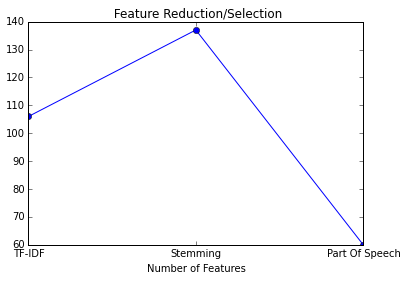

[1.9969820419355528, 1.9063941195781808, 1.7970492692184052]


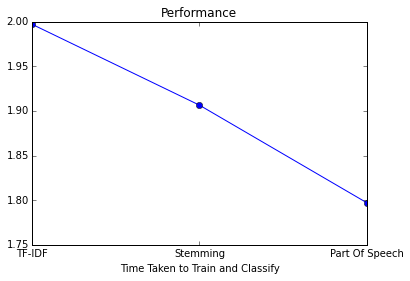

[0.73636363636363633, 0.76363636363636367, 0.68181818181818177]


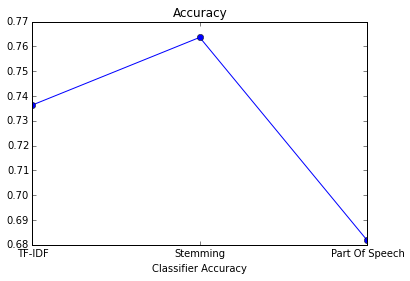

In [131]:
ylabel = ['TF-IDF','Stemming','Part Of Speech']
 
plot_features(Features,ylabel,"Number of Features"," Feature Reduction/Selection")
plot_features(times,ylabel,"Time Taken to Train and Classify","Performance")
plot_features(accuracies,ylabel,"Classifier Accuracy","Accuracy")

### GNB

### Feature Extraction with normal Tokenize

In [132]:
Features=[]
times=[]
accuracies=[]

gnb = GaussianNB()
X_train, Y_train, X_test,Y_test = experiment("ML_Data",tokenizer_fn=tokenize,min_df=3,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))
print "\n Considering Part of Speech of Features"
Features.append(X_train.shape[1])
start_time = timeit.default_timer()
predictedLabels = gnb.fit(X_train.toarray(),Y_train).predict(X_test.toarray())
for l in np.unique(Y_test):
    print " \n Metrics For Class",l,"......."
    p,r = evaluate_performance(predictedLabels,Y_test,1)
end_time = timeit.default_timer()

times.append(end_time - start_time)


accuracies.append(accuracy_score(predictedLabels,Y_test))

<function tokenize at 0x0000000031692198>
Number of Features : (314, 387)

 Considering Part of Speech of Features
 
 Metrics For Class 0 .......
Accuracy 	: 0.863636363636
Recall  	: 0.877192982456
False Negative 	: 0.122807017544
Precision 	: 0.862068965517
False Positive 	: 0.150943396226
True Negative 	: 0.849056603774
F Square 	: 0.869565217391
 
 Metrics For Class 1 .......
Accuracy 	: 0.863636363636
Recall  	: 0.877192982456
False Negative 	: 0.122807017544
Precision 	: 0.862068965517
False Positive 	: 0.150943396226
True Negative 	: 0.849056603774
F Square 	: 0.869565217391


### Feature Extraction for Tokenize with Stemming

In [133]:
gnb = GaussianNB()
X_train, Y_train, X_test,Y_test = experiment("ML_Data",tokenizer_fn=tokenize_with_stemming,min_df=3,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))
print "\n Considering Part of Speech of Features"
Features.append(X_train.shape[1])
start_time = timeit.default_timer()
predictedLabels = gnb.fit(X_train.toarray(),Y_train).predict(X_test.toarray())
for l in np.unique(Y_test):
    print " \n Metrics For Class",l,"......."
    p,r = evaluate_performance(predictedLabels,Y_test,1)
end_time = timeit.default_timer()

times.append(end_time - start_time)


accuracies.append(accuracy_score(predictedLabels,Y_test))



<function tokenize at 0x0000000031692198>
Number of Features : (314, 413)

 Considering Part of Speech of Features
 
 Metrics For Class 0 .......
Accuracy 	: 0.863636363636
Recall  	: 0.754385964912
False Negative 	: 0.245614035088
Precision 	: 0.977272727273
False Positive 	: 0.0188679245283
True Negative 	: 0.981132075472
F Square 	: 0.851485148515
 
 Metrics For Class 1 .......
Accuracy 	: 0.863636363636
Recall  	: 0.754385964912
False Negative 	: 0.245614035088
Precision 	: 0.977272727273
False Positive 	: 0.0188679245283
True Negative 	: 0.981132075472
F Square 	: 0.851485148515


### Feature Extraction for Tokenize with POS

In [134]:
gnb = GaussianNB()
X_train, Y_train, X_test,Y_test = experiment("ML_Data",tokenizer_fn=tokenize_with_POS,min_df=3,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,3))
print "\n Considering Part of Speech of Features"
Features.append(X_train.shape[1])
start_time = timeit.default_timer()
predictedLabels = gnb.fit(X_train.toarray(),Y_train).predict(X_test.toarray())
for l in np.unique(Y_test):
    print " \n Metrics For Class",l,"......."
    p,r = evaluate_performance(predictedLabels,Y_test,1)
end_time = timeit.default_timer()

times.append(end_time - start_time)


accuracies.append(accuracy_score(predictedLabels,Y_test))



<function tokenize at 0x0000000031692198>
Number of Features : (314, 189)

 Considering Part of Speech of Features
 
 Metrics For Class 0 .......
Accuracy 	: 0.8
Recall  	: 0.894736842105
False Negative 	: 0.105263157895
Precision 	: 0.761194029851
False Positive 	: 0.301886792453
True Negative 	: 0.698113207547
F Square 	: 0.822580645161
 
 Metrics For Class 1 .......
Accuracy 	: 0.8
Recall  	: 0.894736842105
False Negative 	: 0.105263157895
Precision 	: 0.761194029851
False Positive 	: 0.301886792453
True Negative 	: 0.698113207547
F Square 	: 0.822580645161


### Graph Plot

[387, 413, 189]


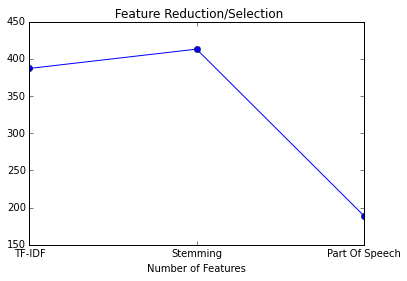

[0.007385166201856919, 0.006077398626075592, 0.0049347056992701255]


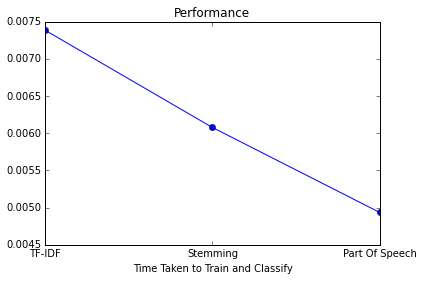

[0.86363636363636365, 0.86363636363636365, 0.80000000000000004]


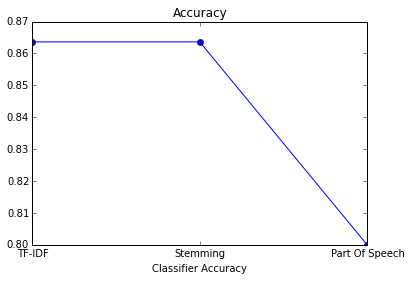

In [135]:

ylabel = ['TF-IDF','Stemming','Part Of Speech']
 
plot_features(Features,ylabel,"Number of Features"," Feature Reduction/Selection")
plot_features(times,ylabel,"Time Taken to Train and Classify","Performance")
plot_features(accuracies,ylabel,"Classifier Accuracy","Accuracy")

## SVM

### Feature Extraction with normal Tokenize

In [136]:
Features=[]
times=[]
accuracies=[]


#Normal Tokenize , no stop , stem SVM 
X_train, Y_train, X_test,Y_test = experiment("ML_Data",tokenizer_fn=tokenize,min_df=1,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,1))


Features.append(X_train.shape[1])
start_time = timeit.default_timer()

predictedLabels = classify_SVM(X_train, Y_train, X_test,Y_test)

end_time = timeit.default_timer()
times.append(end_time - start_time)
accuracies.append(accuracy_score(predictedLabels,Y_test))

<function tokenize at 0x0000000031692198>
Number of Features : (314, 1620)
     pcost       dcost       gap    pres   dres
 0: -1.2193e-02 -3.1692e+02  3e+02  2e-16  2e-16
 1: -4.4073e-01 -4.0093e+00  4e+00  1e-16  4e-16
 2: -4.8939e-01 -5.4629e-01  6e-02  1e-16  1e-16
 3: -4.8970e-01 -4.9029e-01  6e-04  5e-17  6e-17
 4: -4.8970e-01 -4.8971e-01  6e-06  3e-16  1e-16
 5: -4.8970e-01 -4.8970e-01  6e-08  8e-17  4e-17
Optimal solution found.

........... For Class Positive........................
Accuracy 	: 0.863636363636
Recall  	: 0.912280701754
False Negative 	: 0.0877192982456
Precision 	: 0.838709677419
False Positive 	: 0.188679245283
True Negative 	: 0.811320754717
F Square 	: 0.873949579832

............For Class Negative........................
Accuracy 	: 0.863636363636
Recall  	: 0.811320754717
False Negative 	: 0.188679245283
Precision 	: 0.895833333333
False Positive 	: 0.0877192982456
True Negative 	: 0.912280701754
F Square 	: 0.851485148515


### Feature Extraction for Tokenize with Stemming

In [137]:
X_train,Y_train,X_test,Y_test =   experiment("ML_Data",tokenizer_fn=tokenize_with_stemming,min_df=1,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,1))

Features.append(X_train.shape[1])
start_time = timeit.default_timer()

predictedLabels = classify_SVM(X_train, Y_train, X_test,Y_test)

end_time = timeit.default_timer()
times.append(end_time - start_time)
accuracies.append(accuracy_score(predictedLabels,Y_test))

<function tokenize at 0x0000000031692198>
Number of Features : (314, 1448)
     pcost       dcost       gap    pres   dres
 0: -1.2193e-02 -3.1692e+02  3e+02  2e-16  2e-16
 1: -4.4073e-01 -4.0093e+00  4e+00  1e-16  4e-16
 2: -4.8939e-01 -5.4629e-01  6e-02  1e-16  1e-16
 3: -4.8970e-01 -4.9029e-01  6e-04  5e-17  6e-17
 4: -4.8970e-01 -4.8971e-01  6e-06  3e-16  1e-16
 5: -4.8970e-01 -4.8970e-01  6e-08  8e-17  4e-17
Optimal solution found.

........... For Class Positive........................
Accuracy 	: 0.836363636364
Recall  	: 0.824561403509
False Negative 	: 0.175438596491
Precision 	: 0.854545454545
False Positive 	: 0.150943396226
True Negative 	: 0.849056603774
F Square 	: 0.839285714286

............For Class Negative........................
Accuracy 	: 0.836363636364
Recall  	: 0.849056603774
False Negative 	: 0.150943396226
Precision 	: 0.818181818182
False Positive 	: 0.175438596491
True Negative 	: 0.824561403509
F Square 	: 0.833333333333


### Feature Extraction for Tokenize with POS

In [138]:
X_train,Y_train,X_test,Y_test =   experiment("ML_Data",tokenizer_fn=tokenize_with_POS,min_df=1,stop_words=None, max_df=1., binary=True,
            ngram_range=(1,1))
Features.append(X_train.shape[1])
start_time = timeit.default_timer()

predictedLabels = classify_SVM(X_train, Y_train, X_test,Y_test)

end_time = timeit.default_timer()
times.append(end_time - start_time)
accuracies.append(accuracy_score(predictedLabels,Y_test))

<function tokenize at 0x0000000031692198>
Number of Features : (314, 801)
     pcost       dcost       gap    pres   dres
 0: -1.2193e-02 -3.1692e+02  3e+02  2e-16  2e-16
 1: -4.4073e-01 -4.0093e+00  4e+00  1e-16  4e-16
 2: -4.8939e-01 -5.4629e-01  6e-02  1e-16  1e-16
 3: -4.8970e-01 -4.9029e-01  6e-04  5e-17  6e-17
 4: -4.8970e-01 -4.8971e-01  6e-06  3e-16  1e-16
 5: -4.8970e-01 -4.8970e-01  6e-08  8e-17  4e-17
Optimal solution found.

........... For Class Positive........................
Accuracy 	: 0.872727272727
Recall  	: 0.859649122807
False Negative 	: 0.140350877193
Precision 	: 0.890909090909
False Positive 	: 0.11320754717
True Negative 	: 0.88679245283
F Square 	: 0.875

............For Class Negative........................
Accuracy 	: 0.872727272727
Recall  	: 0.88679245283
False Negative 	: 0.11320754717
Precision 	: 0.854545454545
False Positive 	: 0.140350877193
True Negative 	: 0.859649122807
F Square 	: 0.87037037037


### Graph Plot

[1620, 1448, 801]


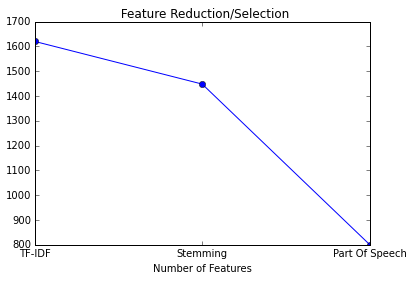

[0.2134791578282602, 0.16871826803253498, 0.18344797325698892]


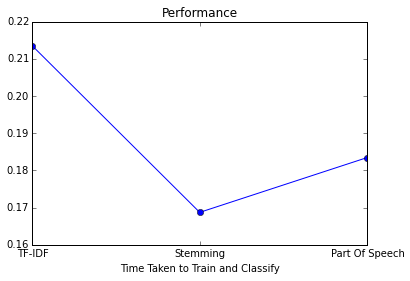

[0.86363636363636365, 0.83636363636363631, 0.87272727272727268]


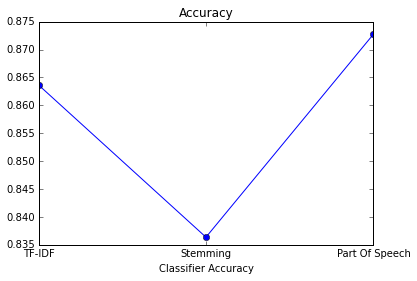

In [139]:
ylabel = ['TF-IDF','Stemming','Part Of Speech']
 
plot_features(Features,ylabel,"Number of Features"," Feature Reduction/Selection")
plot_features(times,ylabel,"Time Taken to Train and Classify","Performance")
plot_features(accuracies,ylabel,"Classifier Accuracy","Accuracy")